# **Projeto - IA 2 - Deep Learning -Análise de Radiografia de Pulmões**

---
#### PROFESSOR CESAR
#### ALUNOS: `MARCIO FERNANDES CRUZ`
#### LABDATA - AGOSTO/2022
---
<img align="center" width="200" src="https://logodownload.org/wp-content/uploads/2020/03/covid-19-logo.png">



# **Importação de Bibliotecas**

In [ ]:
random_state = 20220731

from google.colab import drive
drive.mount('/content/drive')

from google.colab import auth
auth.authenticate_user()

from IPython.display import clear_output

import requests
gcloud_token = !gcloud auth print-access-token
gcloud_tokeninfo = requests.get('https://www.googleapis.com/oauth2/v3/tokeninfo?access_token=' + gcloud_token[0]).json()

email_logado = gcloud_tokeninfo['email']

import numpy as np
from sklearn.model_selection import train_test_split
from random import sample
import os
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

from keras.applications import vgg16 as vgg
from keras.preprocessing import image as im
from keras.applications import vgg16 as vgg
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.applications import Xception

from keras.models import Model, Sequential
from keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

clear_output()

# **Funções Utilizadas no Notebook**

In [ ]:
# Varre determinado diretório e gera uma lista respeitando o numero máximo de Observações
def get_lista_observacoes(pasta, limite_observacoes):
  if (limite_observacoes<len(os.listdir(pasta))):
    return sample(os.listdir(pasta), limite_observacoes)
  else:
    return os.listdir(pasta)

# A partir de uma lista de imagem, retorna um array de imagens e suas classes com o objetivo de "Fitar" o modelo
def get_lista_imagens(pasta, lista_observacoes, classe, target_width, target_height, aplicar_normalizacao):
  imagens, classes = [], []

  for arquivo in lista_observacoes:
    caminho_arquivo = os.path.join(pasta, arquivo)
    imagem_original = im.img_to_array(im.load_img(caminho_arquivo, target_size=(target_width, target_height)))

    if (aplicar_normalizacao==True):
      imagens.append(vgg.preprocess_input(imagem_original))
    else:
      imagens.append(imagem_original)

    classes.append(np.array(int(classe)))

  imagens = np.array(imagens)
  classes = np.array(classes)

  return imagens, classes

def get_acuracia_base_teste(history):
  return np.mean(history.history['val_accuracy'])

def get_variabilidade_base_teste(history):
  return np.std(history.history['val_accuracy'])

def get_grafico_analise(history):
  fig, (ax1, ax2) = plt.subplots(1, 2)

  fig.set_figwidth(30)
  fig.set_figheight(5)

  ax1.plot(history.history['loss'], label='Erro no Treinamento')
  ax1.plot(history.history['val_loss'], label='Erro no Teste')
  ax1.set_title('Análise de Erro')
  ax1.set_ylabel('Loss')
  ax1.set_xlabel('Época')
  ax1.legend();

  ax2.plot(history.history['accuracy'], label='Acurácia no Treino')
  ax2.plot(history.history['val_accuracy'], label='Acurácia no Teste')
  ax2.set_title('Análise da Acurácia')
  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Época')
  ax2.legend();

  fig.suptitle('Análise Gráfica')
  fig.show()


# Função para exibir a avaliação na base de Teste
def exibir_avaliacao(history):
  print('Acurácia na Base de Teste: ', get_acuracia_base_teste(history))
  print('Variabilidade na Base de Teste: ', get_variabilidade_base_teste(history))
  get_grafico_analise(history)

# Usado nos métodos de Teste para Exibir o Pivot
def exibir_pivot_teste(modelo, imagens_test, classes_test):
  classificacoes = modelo.predict(imagens_test)
  classificacoes_modelo = (i.argmax() for i in classificacoes)

  matrix_dataframe = pd.DataFrame({'classe_original': classes_test, 'classe_modelo': classificacoes_modelo}, index=range(imagens_test.shape[0]))
  matrix_dataframe['count'] = 1

  pivot = matrix_dataframe.pivot_table(values = 'count', index='classe_original', columns='classe_modelo', aggfunc='sum').fillna(0)

  pivot.rename(index={0: 'Normal', 1: 'Pneumo-Bact', 2: 'Pneumo-Viral', 3: 'Covid' },
              columns={0: 'Normal', 1: 'Pneumo-Bact', 2: 'Pneumo-Viral', 3: 'Covid' }, inplace=True)

  print(pivot)
  plt.figure(figsize=(20,8))
  sb.heatmap(pivot / pivot.sum(axis=1), cmap='YlGnBu', annot=True, annot_kws={"fontsize":12});

def exibir_pivot_validacao(df):
  pivot = df.pivot_table(values = 'count', index='classe_original', columns='classe_modelo', aggfunc='sum').fillna(0)

  pivot.rename(index={0: 'Normal', 1: 'Pneumo-Bact', 2: 'Pneumo-Viral', 3: 'Covid' },
              columns={0: 'Normal', 1: 'Pneumo-Bact', 2: 'Pneumo-Viral', 3: 'Covid' }, inplace=True)

  print(pivot)
  plt.figure(figsize=(20,8))
  sb.heatmap(pivot / pivot.sum(axis=1), cmap='YlGnBu', annot=True, annot_kws={"fontsize":12});


# Função criada para executar previsões sobre arquivos unitários e alimentar em 1 array
def get_df_previsao(modelo, pasta, lista_observacoes, classe, target_width, target_height, aplicar_normalizacao):

  df_resultado = pd.DataFrame(columns=['classe_original', 'classe_modelo', 'count'])

  for arquivo in lista_observacoes:
    caminho = os.path.join(pasta, arquivo)
    imagem = im.img_to_array(im.load_img(caminho, target_size=(target_width, target_height)))

    if (aplicar_normalizacao==True):
      imagem = vgg.preprocess_input(imagem)

    imagem = np.expand_dims(imagem, axis=0)

    classificacao = modelo.predict(imagem)

    dicionario = dict(classe_original = classe,
                classe_modelo = classificacao.argmax(),
                count= 1)
    df_auxiliar = pd.DataFrame([dicionario])

    df_resultado = pd.concat([df_resultado, df_auxiliar])

  return df_resultado

# **Configurações que podem ser trocadas pelo Usuário**

In [ ]:
# Definir limite de arquivos a serem observados e tamanho de imagem
limite_observacoes = 500

ratio = (400/300)

target_width = 80 # Para XCepion, no minimo 71
target_height = round(target_width*ratio)
limite_predicoes = 200
epocas = 10


# Verifiquei que o shape da imagem normal é 300 x 400 por 3 canais, mas as outras com doença associada possuem tamanhos maiores

# Definir caminhos das pastas onde estão as observaçòes
if email_logado=='marcio@marciofcruz.com':
  pasta_raiz = '/content/drive/MyDrive/Colab Notebooks/DataSet Data Science/imagenspulmao/Curated X-Ray Dataset'
elif email_logado=='alissondeandrade@gmail.com':
  pasta_raiz = '/content/drive/MyDrive/Colab Notebooks/DataSet Data Science/imagenspulmao/Curated X-Ray Dataset'
elif email_logado=='sonekabolyhos@gmail.com':
  pasta_raiz = '/content/drive/MyDrive/Colab Notebooks/DataSet Data Science/imagenspulmao/Curated X-Ray Dataset'
elif email_logado=='prv.viegas@gmail.com':
  pasta_raiz = '/content/drive/MyDrive/Colab Notebooks/DataSet Data Science/imagenspulmao/Curated X-Ray Dataset'
else:
  pasta_raiz = "Não encontrado o email"

pasta_normal = os.path.join(pasta_raiz, 'Normal')
pasta_pneumonia_bacterial = os.path.join(pasta_raiz, 'Pneumonia-Bacterial')
pasta_pneumonia_viral = os.path.join(pasta_raiz, 'Pneumonia-Viral')
pasta_covid_19  = os.path.join(pasta_raiz, 'COVID-19')

print(f'A pasta raiz do {email_logado} é {pasta_raiz}')

if (not os.path.exists(pasta_normal)):
  print('Caminho não existe: ', pasta_normal, ':', len(os.listdir(pasta_normal)))

if (not os.path.exists(pasta_normal)):
  print('Caminho não existe: ', pasta_pneumonia_bacterial, ':', len(os.listdir(pasta_pneumonia_bacterial)))

if (not os.path.exists(pasta_normal)):
  print('Caminho não existe: ', pasta_pneumonia_viral, ':', len(os.listdir(pasta_pneumonia_viral)))

if (not os.path.exists(pasta_normal)):
  print('Caminho não existe: ', pasta_covid_19, ':', len(os.listdir(pasta_covid_19)))

observacoes_normal = get_lista_observacoes(pasta_normal, limite_observacoes)
observacoes_pneunomia_bacterial = get_lista_observacoes(pasta_pneumonia_bacterial, limite_observacoes)
observacoes_pneunomia_viral = get_lista_observacoes(pasta_pneumonia_viral, limite_observacoes)
observacoes_covid_19 = get_lista_observacoes(pasta_covid_19, limite_observacoes)

# Lista de imagens para Validação onde nõo estou considerando imagens já procesadas
observacoes_normal_validacao = sample(list(set(os.listdir(pasta_normal)) - set(observacoes_normal)), limite_predicoes)
observacoes_pneumonia_bacterial_validacao  = sample(list(set(os.listdir(pasta_pneumonia_bacterial)) - set(observacoes_pneunomia_bacterial)), limite_predicoes)
observacoes_pneumonia_viral_validacao  = sample(list(set(os.listdir(pasta_pneumonia_viral)) - set(observacoes_pneunomia_viral)), limite_predicoes)
observacoes_covid_19_validacao  = sample(list(set(os.listdir(pasta_covid_19)) - set(observacoes_covid_19)), limite_predicoes)

A pasta raiz do marcio@marciofcruz.com é /content/drive/MyDrive/Colab Notebooks/DataSet Data Science/imagenspulmao/Curated X-Ray Dataset


# **Carregar Array de Imagens e Classes**

In [ ]:
imagens_normal, classes_normal = get_lista_imagens(pasta_normal, observacoes_normal, 0, target_width, target_height, True)
imagens_pneumonia_bacterial, classes_pneumonia_bacterial = get_lista_imagens(pasta_pneumonia_bacterial, observacoes_pneunomia_bacterial, 1, target_width, target_height, True)
imagens_pneumonia_viral, classes_pneumonia_viral = get_lista_imagens(pasta_pneumonia_viral ,observacoes_pneunomia_viral, 2, target_width, target_height, True)
imagens_covid_19, classes_covid_19 = get_lista_imagens(pasta_covid_19, observacoes_covid_19, 3, target_width, target_height, True)

# Separar Train e Test
imagens_normal_train, imagens_normal_test, classes_normal_train, classes_normal_test = train_test_split(imagens_normal, classes_normal, test_size=0.5, random_state=random_state)
imagens_pneumonia_bacterial_train, imagens_pneumonia_bacterial_test, classes_pneumonia_bacterial_train, classes_pneumonia_bacterial_test = train_test_split(imagens_pneumonia_bacterial, classes_pneumonia_bacterial, test_size=0.5, random_state=random_state)
imagens_pneumonia_viral_train, imagens_pneumonia_viral_test, classes_pneumonia_viral_train, classes_pneumonia_viral_test = train_test_split(imagens_pneumonia_viral, classes_pneumonia_viral, test_size=0.5, random_state=random_state)
imagens_covid_19_train, imagens_covid_19_test, classes_covid_19_train, classes_covid_19_test = train_test_split(imagens_covid_19, classes_covid_19, test_size=0.5, random_state=random_state)

imagens_train = np.concatenate((imagens_normal_train, imagens_pneumonia_bacterial_train, imagens_pneumonia_viral_train, imagens_covid_19_train))
classes_train = np.concatenate((classes_normal_train, classes_pneumonia_bacterial_train, classes_pneumonia_viral_train, classes_covid_19_train))
classes_train_cat = to_categorical(classes_train, 4) # Categorizar as 4 classes - Normal, Covid, Pneumonia Viral e Bacteriana

imagens_test = np.concatenate((imagens_normal_test, imagens_pneumonia_bacterial_test, imagens_pneumonia_viral_test, imagens_covid_19_test))
classes_test = np.concatenate((classes_normal_test, classes_pneumonia_bacterial_test, classes_pneumonia_viral_test, classes_covid_19_test))
classes_test_cat = to_categorical(classes_test, 4) # Categorizar as 4 classes - Normal, Covid, Pneumonia Viral e Bacteriana

# Apagar objetos para economizar RAM
del imagens_normal_train, imagens_pneumonia_bacterial_train, imagens_pneumonia_viral_train, imagens_covid_19_train
del classes_normal_train, classes_pneumonia_bacterial_train, classes_pneumonia_viral_train, classes_covid_19_train

del imagens_normal_test, imagens_pneumonia_bacterial_test, imagens_pneumonia_viral_test, imagens_covid_19_test
del classes_normal_test, classes_pneumonia_bacterial_test, classes_pneumonia_viral_test, classes_covid_19_test


# **Arquitetura VGG16**

## Inicialização e Compilação

Acurácia na Base de Teste:  0.7583000004291535
Variabilidade na Base de Teste:  0.025159686262406243


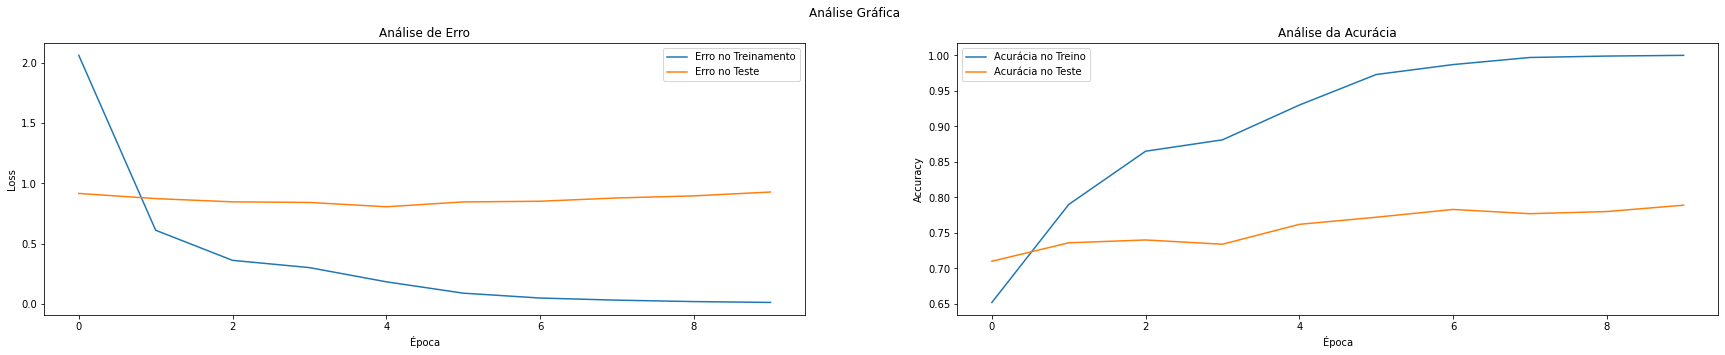

In [ ]:
base_vgg = vgg.VGG16(weights='imagenet', include_top=False, input_shape=(target_width, target_height, 3))
base_vgg.trainable = False

modelo = Sequential(base_vgg)
modelo.add(Flatten())
modelo.add(Dense(64, activation='relu'))
modelo.add(Dense(32, activation='relu'))
modelo.add(Dense(4, activation='softmax'))

# modelo.summary()

# Compilar o Modelo
modelo.compile(loss='categorical_crossentropy', #loss=tf.losses.SparseCategoricalCrossentropy(),
              optimizer='adam',
              metrics=['accuracy'])

# Fitar o Modelo
history = modelo.fit(imagens_train, classes_train_cat, epochs=epocas, validation_data=(imagens_test, classes_test_cat))
clear_output()

# Exibir a Avaliação do Modelo
exibir_avaliacao(history)

## Resultados sobre a base de Teste

classe_modelo    Normal  Pneumo-Bact  Pneumo-Viral  Covid
classe_original                                          
Normal              228            8            13      1
Pneumo-Bact           3          181            60      6
Pneumo-Viral          7           98           142      3
Covid                 8            3             1    238


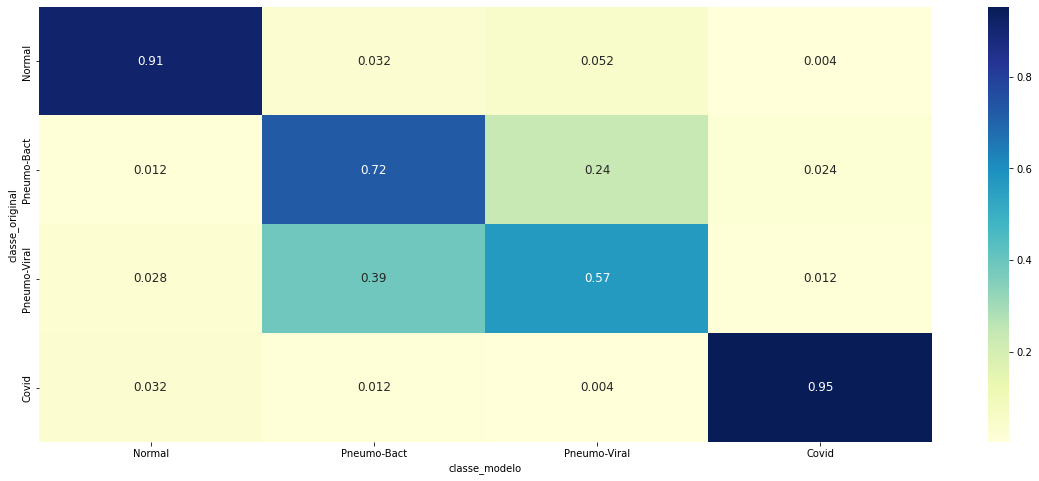

In [ ]:
exibir_pivot_teste(modelo, imagens_test, classes_test)

## Validação

classe_modelo    Normal  Pneumo-Bact  Pneumo-Viral  Covid
classe_original                                          
Normal            190.0          2.0           8.0    0.0
Pneumo-Bact         2.0        144.0          50.0    4.0
Pneumo-Viral        7.0         65.0         126.0    2.0
Covid               5.0          3.0           3.0  189.0


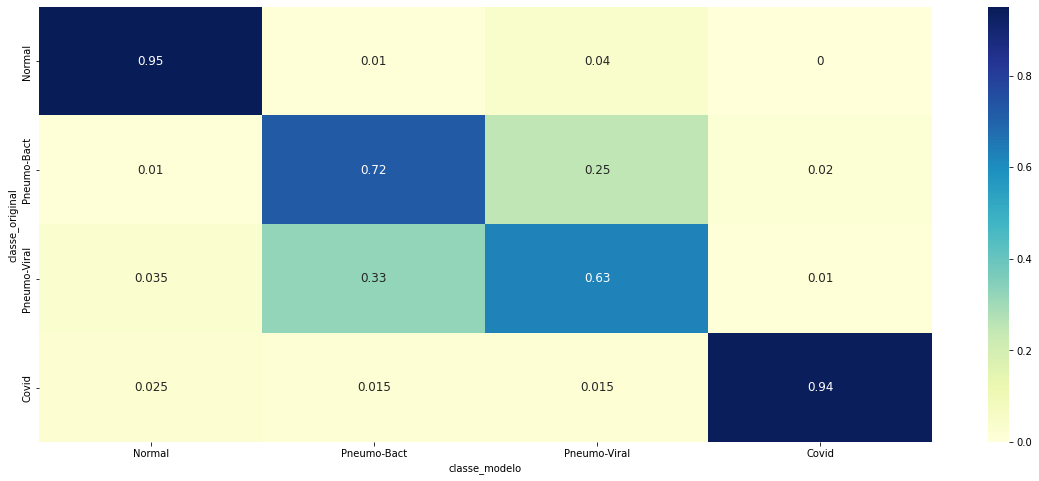

In [ ]:
df_normal_validacao = get_df_previsao(modelo, pasta_normal, observacoes_normal_validacao, 0, target_width, target_height, True)
df_observacoes_pneumonia_bacterial_validacao = get_df_previsao(modelo, pasta_pneumonia_bacterial, observacoes_pneumonia_bacterial_validacao, 1, target_width, target_height, True)
df_observacoes_pneumonia_viral_validacao = get_df_previsao(modelo, pasta_pneumonia_viral, observacoes_pneumonia_viral_validacao, 2, target_width, target_height, True)
df_observacoes_covid_19_validacao = get_df_previsao(modelo, pasta_covid_19, observacoes_covid_19_validacao, 3, target_width, target_height, True)

exibir_pivot_validacao(pd.concat([df_normal_validacao,
                                  df_observacoes_pneumonia_bacterial_validacao,
                                  df_observacoes_pneumonia_viral_validacao,
                                  df_observacoes_covid_19_validacao]))

## Conclusões

Os resultados na base de Treinamento estão parecidos com a base de Validação.
O modelo para a rede VGG6 mostram que identificou corretamente radiografias onde há normalidade e também quando há COVID.
Quanto a detecção de Pneumonia, o modelo consegue identificar mas, não consegue distinguir bem se é Bacterial ou Viral.

# **Arquitetura ResNet 50**

## Inicialização e Compilação

Acurácia na Base de Teste:  0.7737999975681304
Variabilidade na Base de Teste:  0.033008492019290264


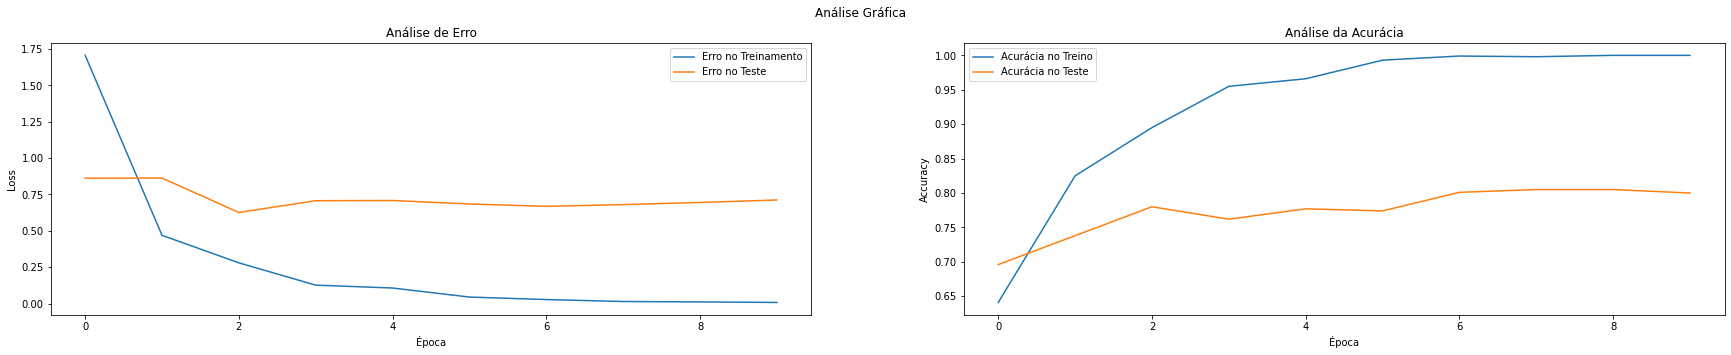

In [ ]:
base_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(target_width, target_height, 3))
base_resnet.trainable = False

modelo = Sequential(base_resnet)
modelo.add(Flatten())
modelo.add(Dense(64, activation='relu'))
modelo.add(Dense(32, activation='relu'))
modelo.add(Dense(4, activation='softmax'))

modelo.compile(loss='categorical_crossentropy', #loss=tf.losses.SparseCategoricalCrossentropy(),
              optimizer='adam',
              metrics=['accuracy'])

clear_output()

history = modelo.fit(imagens_train, classes_train_cat, epochs=epocas, validation_data=(imagens_test, classes_test_cat))
clear_output()

exibir_avaliacao(history)

## Resultados sobre a base de Teste

classe_modelo    Normal  Pneumo-Bact  Pneumo-Viral  Covid
classe_original                                          
Normal              237            4             7      2
Pneumo-Bact           9          164            73      4
Pneumo-Viral         17           73           159      1
Covid                 6            3             1    240


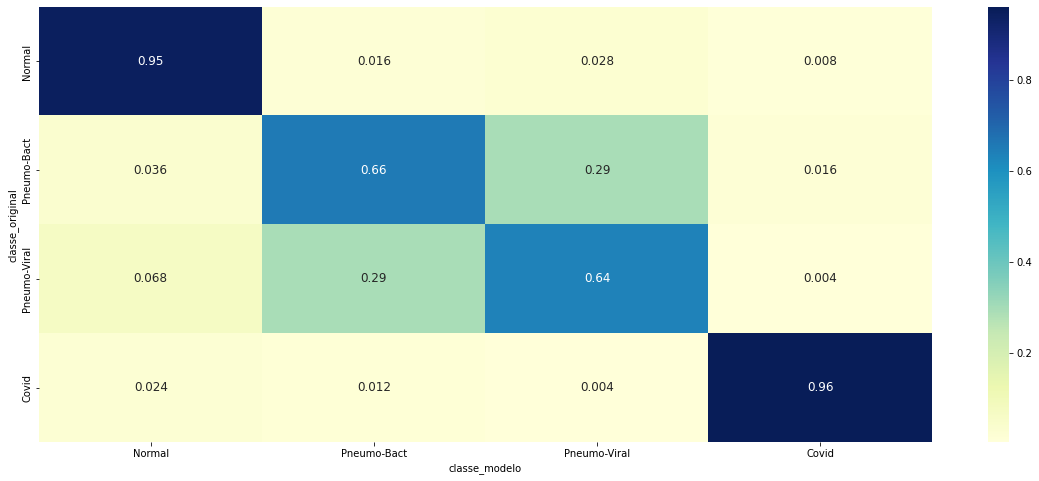

In [ ]:
exibir_pivot_teste(modelo, imagens_test, classes_test)

## `Validação`

classe_modelo    Normal  Pneumo-Bact  Pneumo-Viral  Covid
classe_original                                          
Normal            187.0          6.0           7.0    0.0
Pneumo-Bact         6.0        131.0          59.0    4.0
Pneumo-Viral        9.0         53.0         138.0    0.0
Covid               8.0          2.0           4.0  186.0


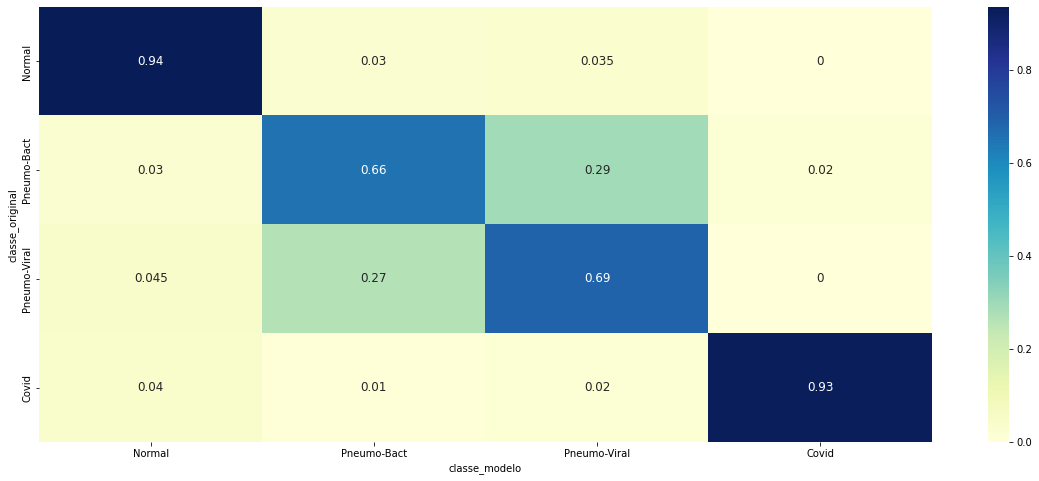

In [ ]:
df_normal_validacao = get_df_previsao(modelo, pasta_normal, observacoes_normal_validacao, 0, target_width, target_height, True)
df_observacoes_pneumonia_bacterial_validacao = get_df_previsao(modelo, pasta_pneumonia_bacterial, observacoes_pneumonia_bacterial_validacao, 1, target_width, target_height, True)
df_observacoes_pneumonia_viral_validacao = get_df_previsao(modelo, pasta_pneumonia_viral, observacoes_pneumonia_viral_validacao, 2, target_width, target_height, True)
df_observacoes_covid_19_validacao = get_df_previsao(modelo, pasta_covid_19, observacoes_covid_19_validacao, 3, target_width, target_height, True)

exibir_pivot_validacao(pd.concat([df_normal_validacao,
                                  df_observacoes_pneumonia_bacterial_validacao,
                                  df_observacoes_pneumonia_viral_validacao,
                                  df_observacoes_covid_19_validacao]))

## Conclusões

Os números apresentados foram ligeiramente melhores que o modelo VGG 16.

# **Arquitetura Xception**

## Inicialização e Compilação

Acurácia na Base de Teste:  0.6510999977588654
Variabilidade na Base de Teste:  0.04971809817507618


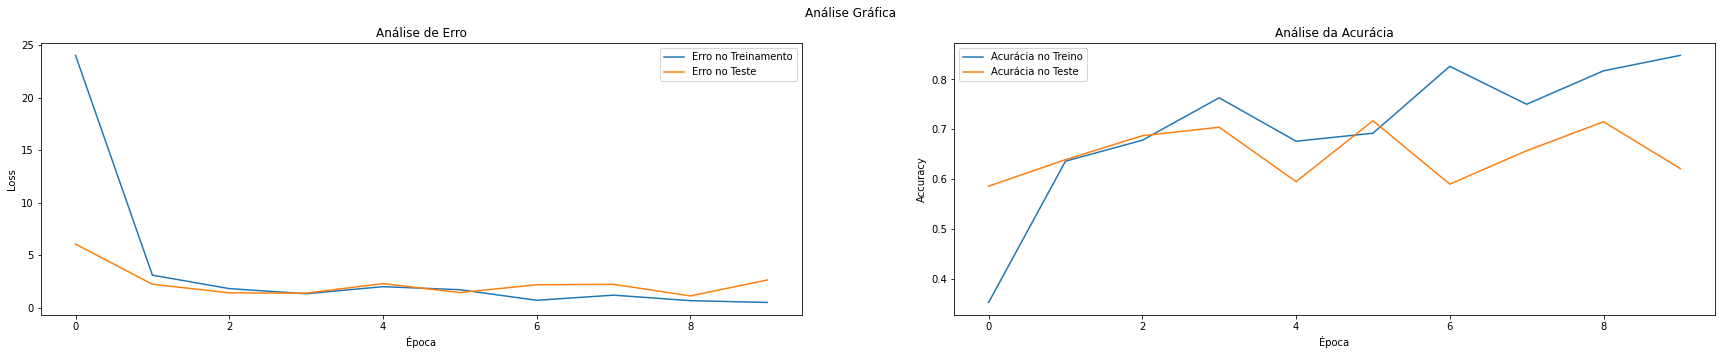

In [ ]:
if (target_width>=71):
  base_model = Xception(weights='imagenet', include_top=False, input_shape=(target_width, target_height, 3))
  base_model.trainable = False

  modelo = Sequential(base_model)
  modelo.add(Flatten())
  modelo.add(Dense(64, activation='relu'))
  modelo.add(Dense(32, activation='relu'))
  modelo.add(Dense(4, activation='softmax'))

  modelo.compile(loss='categorical_crossentropy', #loss=tf.losses.SparseCategoricalCrossentropy(),
                optimizer='adam',
                metrics=['accuracy'])

  clear_output()

  history = modelo.fit(imagens_train, classes_train_cat, epochs=epocas, validation_data=(imagens_test, classes_test_cat))
  clear_output()

  exibir_avaliacao(history)

## Resultados sobre a base de Teste

classe_modelo    Normal  Pneumo-Bact  Pneumo-Viral  Covid
classe_original                                          
Normal            167.0          0.0          75.0    8.0
Pneumo-Bact         2.0          5.0         237.0    6.0
Pneumo-Viral        6.0          4.0         232.0    8.0
Covid               3.0          1.0          29.0  217.0


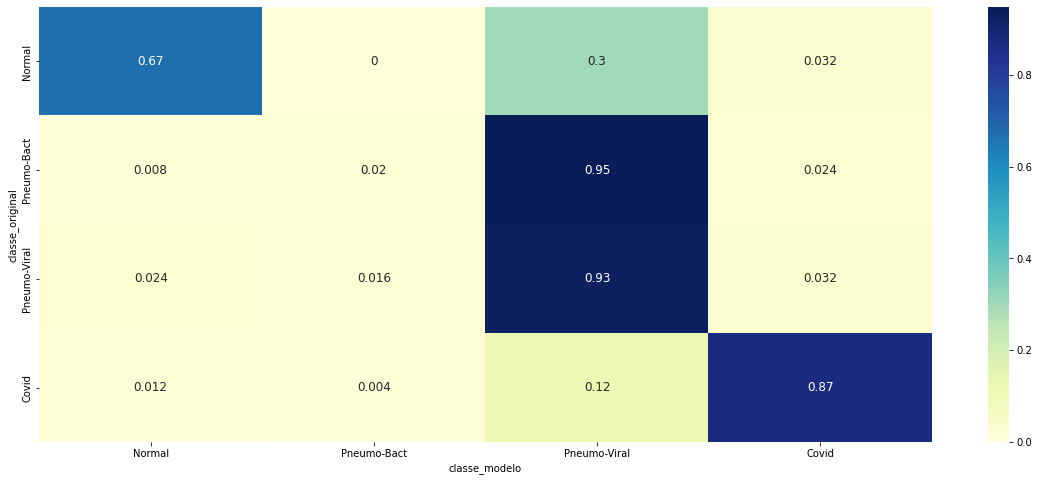

In [ ]:
if (target_width>=71):
  exibir_pivot_teste(modelo, imagens_test, classes_test)

## Validação

classe_modelo    Normal  Pneumo-Bact  Pneumo-Viral  Covid
classe_original                                          
Normal            131.0          0.0          64.0    5.0
Pneumo-Bact         3.0          3.0         189.0    5.0
Pneumo-Viral        4.0          3.0         191.0    2.0
Covid               3.0          0.0          27.0  170.0


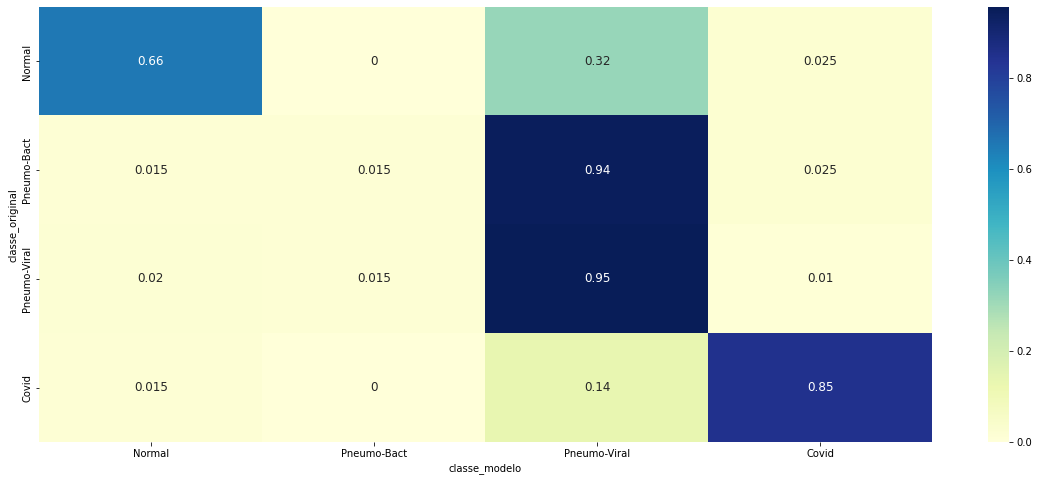

In [ ]:
if (target_width>=71):
  df_normal_validacao = get_df_previsao(modelo, pasta_normal, observacoes_normal_validacao, 0, target_width, target_height, True)
  df_observacoes_pneumonia_bacterial_validacao = get_df_previsao(modelo, pasta_pneumonia_bacterial, observacoes_pneumonia_bacterial_validacao, 1, target_width, target_height, True)
  df_observacoes_pneumonia_viral_validacao = get_df_previsao(modelo, pasta_pneumonia_viral, observacoes_pneumonia_viral_validacao, 2, target_width, target_height, True)
  df_observacoes_covid_19_validacao = get_df_previsao(modelo, pasta_covid_19, observacoes_covid_19_validacao, 3, target_width, target_height, True)

  exibir_pivot_validacao(pd.concat([df_normal_validacao,
                                    df_observacoes_pneumonia_bacterial_validacao,
                                    df_observacoes_pneumonia_viral_validacao,
                                    df_observacoes_covid_19_validacao]))

## Conclusões

sfdsfsfdsfa

# **Conclusão Final sobre o Experimento**

Com 500 observações seperadas, onde foi treinado 250, obteve-se na Validação resultados parecidos com a base de Teste.

Tomou-se ocupado de manter a proporção 4/3 para as imagens, já que geralmente as radiografias são neste formato.

E, na rede ResNet apresentou os melhores resultados...
etc
etc
Em questões de Época, mais do que X épocas não apresenta melhora significativa do modelo.

Qualquer modelo tem acurácia acima de 80% para identificar se apresenta um aspecto normal.
Para COVID, também apresenta acurácia boa.
Mas, para Pneumonia Bacteriana ou Viral, apenas a rede Xception mostrou eficiência na detecção .

Será necessário fazer novas análises, e, talvez colocar 2 modelos em sequência para tentar identificar se a radiografia tem aspecto normal e, talvez outros modelos para identificar eventual infecção que é apresentado.
